# QA4U lecture 4

## previous lecture

In [2]:
import pandas as pd
df = pd.read_csv('QA4Uafter.csv',header=None)

import numpy as np
V = df.values.astype(np.int8)
N,M = V.shape

def onehot(data):
  z = np.zeros(4+3+5+7)
  z[data[0]-1] = 1
  z[4+data[1]-1] = 1
  z[4+3+data[2]-1] = 1
  z[4+3+5+data[3]-1] = 1
  return z

M = 4+3+5+7
Z = np.zeros(N*M).reshape(N,M)

for i in range(N):
  Z[i,:] = onehot(V[i,:])

## Boltzmann machine learning
Assume the previous questionnaire's results are the QA's output. <br>
The sum of one item must be equal to 1<br>
第一項目について
\begin{equation}
x_1+x_2+x_3+x_4 = 1
\end{equation}
第二項目について
\begin{equation}
x_5+x_6+x_7 = 1
\end{equation}
第三項目については
\begin{equation}
x_8+x_9+x_{10}+x_{11}+x_{12} = 1
\end{equation}
第四項については
\begin{equation}
x_{13}+x_{14}+x_{15}+x_{16}+x_{17}+x_{18}+x_{19} = 1
\end{equation}

consider the penalty method
\begin{equation}
E({\bf x}) = \sum_{m}\sum_{n} Q_{mn} x_{m} x_{n} + \lambda_1\left( x_1+x_2+x_3+x_4 -1 \right)^2 + \lambda_2 \left( x_5+x_6+x_7 -1 \right)^2 + \lambda_3 \left( x_8+x_9+x_{10}+x_{11}+x_{12} - 1\right)^2 + \lambda_4 \left( x_{13}+x_{14}+x_{15}+x_{16}+x_{17}+x_{18}+x_{19} - 1\right)^2
\end{equation}

The value of $x$ can be adjusted via controlling the $Q$ matrix. If $Q$ is large, $x$ would prefer to be small; otherwise, $x$ would be large. 

To know whether this $x$ should be larger or smaller, we need an item to be compared with. lets compute the average of all $Z$s and $x$s
\begin{equation}
Q_{mn} = Q_{mn} - \eta\left( \frac{1}{N}\sum_{i=1}^N Z_{im}Z_{in} - \frac{1}{N'} \sum_{i=1}^{N'} x_{im}x_{in}\right)
\end{equation}
where $N$ is the total number, $\eta$ is the learning rate

In [3]:
Qc = np.zeros(M**2).reshape(M,M)

lam = 10.0

for m in range(4):
  for n in range(4):
    Qc[m,n] = Qc[m,n] + lam
    if m == n:
      Qc[m,n] = Qc[m,n] -2*lam

for m in range(4,4+3):
  for n in range(4,4+3):
    Qc[m,n] = Qc[m,n] + lam
    if m == n:
      Qc[m,n] = Qc[m,n] -2*lam

for m in range(4+3,4+3+5):
  for n in range(4+3,4+3+5):
    Qc[m,n] = Qc[m,n] + lam
    if m == n:
      Qc[m,n] = Qc[m,n] -2*lam

for m in range(4+3+5,4+3+5+7):
  for n in range(4+3+5,4+3+5+7):
    Qc[m,n] = Qc[m,n] + lam
    if m == n:
      Qc[m,n] = Qc[m,n] -2*lam

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-jzz2gdff because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


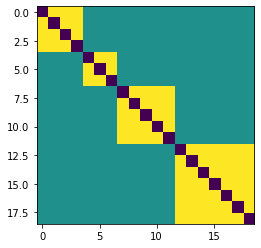

In [4]:
# visualization
import matplotlib.pyplot as plt
plt.imshow(Qc)
plt.show()

In [5]:
# initial values
Q = np.zeros(M**2).reshape(M,M)
Qmat = Q+Qc

In [7]:
# convert array to dict
def array2dict(Q):
    Qdict = {}
    for i in range(Q.shape[0]):
        for j in range(Q.shape[1]):
            Qdict[(i,j)] = Q[i][j]
    return Qdict

Qdict = array2dict(Qmat)

In [12]:
# QA
from openjij import SQASampler
sim_sampler = SQASampler()
Nsample = 100

# wait for a little bit long time due to large prob size
sampleset = sim_sampler.sample_qubo(Qdict, num_reads = Nsample)

In [13]:
# reshape
x = np.zeros(Nsample*M).reshape(Nsample,M)
for k in range(Nsample):
  x[k,:] = sampleset.record[k][0]

In [14]:
# average
Zmat = np.dot(Z.T,Z)/N
Xmat = np.dot(x.T,x)/Nsample

In [19]:
# implement equation
eta = 0.1
Q = Q - eta*(Zmat-Xmat)
Qmat = Q + Qc
Qdict = array2dict(Qmat)

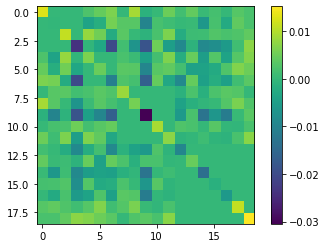

In [16]:
# visualization
plt.imshow(Q)
plt.colorbar()
plt.show()

learning only one iteration could not give us good imitation result.<br>
Lets do it in a few more iterations

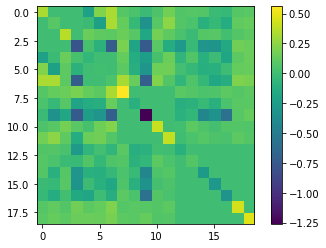

In [21]:
from IPython.display import clear_output

Tall = 50
for t in range(Tall):
    sampleset = sim_sampler.sample_qubo(Qdict,num_reads = Nsample)
    x = np.zeros(Nsample*M).reshape(Nsample,M)
    for k in range(Nsample):
    x[k,:] = sampleset.record[k][0]
    Xmat = np.dot(x.T,x)/Nsample
    Q = Q - eta*(Zmat-Xmat)
    Qmat = Q + Qc

    # plot the result in animation
    clear_output(True)
    plt.imshow(Q)
    plt.colorbar()
    plt.show()

### result analysis
now we finish the learning, from the QUBO matrix, we want to know the feature of the quationnaire

In [23]:
# to analyze the first question
## the smaller value in QUBO, the larger possibility to become an 1 for Qbit
print(Q[0,4],Q[0,5],Q[0,6],Q[0,7])

-0.2145934959349594 0.2164471544715446 0.3287235772357726 0.08230894308943094


In [26]:
# second Q
print(Q[1,4],Q[1,5],Q[1,6],Q[1,7])

-0.017040650406504064 -0.22700813008130086 0.33317073170731726 0.12944715447154465


In [27]:
# third Q
print(Q[2,4],Q[2,5],Q[2,6],Q[2,7])

0.14630894308943088 0.11275609756097568 0.10551219512195129 0.15186178861788624


In [28]:
# fourth Q
print(Q[3,4],Q[3,5],Q[3,6],Q[3,7])

0.028821138211382137 -0.09014634146341464 -0.7229512195121955 0.19744715447154473
